In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
device = 'cuda'
torch.manual_seed(0)
np.random.seed(0)

In [16]:

num_epochs_first =20  # epochs for training on task 1
num_epochs_second =20  # epochs for training on task 2
batch_size = 64
learning_rate = 0.01

In [17]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

In [18]:
# Define data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load full MNIST training and test datasets
full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
full_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [38]:
# Define label groups for task 1 and task 2.
class PermutedMNIST(Dataset):
    def __init__(self, original_dataset, permutation):
        self.dataset = original_dataset
        self.permutation = permutation

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img = img.view(-1)  # flatten
        img = img[self.permutation]  # apply permutation
        return img.view(1, 28, 28), label

    def __len__(self):
        return len(self.dataset)

# Create data loaders
train_loader_task1 = DataLoader(dataset=full_train_dataset, batch_size=batch_size, shuffle=True)
# train_loader_task2 = DataLoader(dataset=permuted_train_dataset, batch_size=batch_size, shuffle=True)
test_loader_task1 = DataLoader(dataset=full_test_dataset, batch_size=batch_size, shuffle=True)
# test_loader_task2 = DataLoader(dataset=permuted_test_dataset, batch_size=batch_size, shuffle=True)

In [47]:
def train_model(model, optimizer, criterion, data_loader, test_loader, epochs):
    model.train()
    acc1s = []
    acc2s = []
    for epoch in range(epochs):
        running_loss = 0.0
        iteration_count = 0
        eval_interval = 5
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            iteration_count += 1

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader):.4f}")
        acc1 = evaluate(model, test_loader_task1)
        acc2 = evaluate(model, data_loader)
        acc1s.append(acc1)
        acc2s.append(acc2)
    plt.figure()
    plt.plot(acc1s, label='Task 1 (Ordered)')
    plt.plot(acc2s, label='Task 2 (Permuted)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()




def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

=== Training on Task 1 ===
Epoch [1/5], Loss: 0.6032
Epoch [2/5], Loss: 0.3022
Epoch [3/5], Loss: 0.2570
Epoch [4/5], Loss: 0.2257
Epoch [5/5], Loss: 0.2016


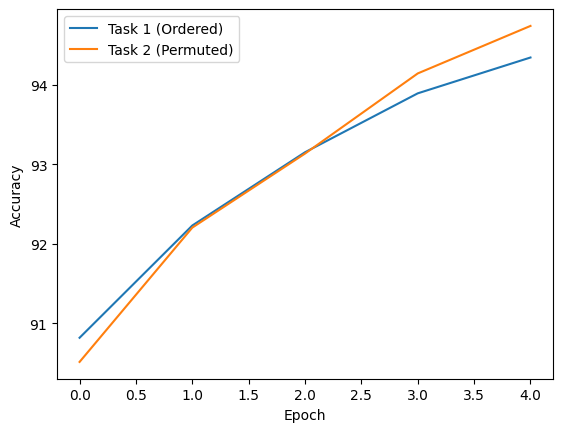

Training permuatation 1
Epoch [1/5], Loss: 0.4412
Epoch [2/5], Loss: 0.2530
Epoch [3/5], Loss: 0.2101
Epoch [4/5], Loss: 0.1833
Epoch [5/5], Loss: 0.1640


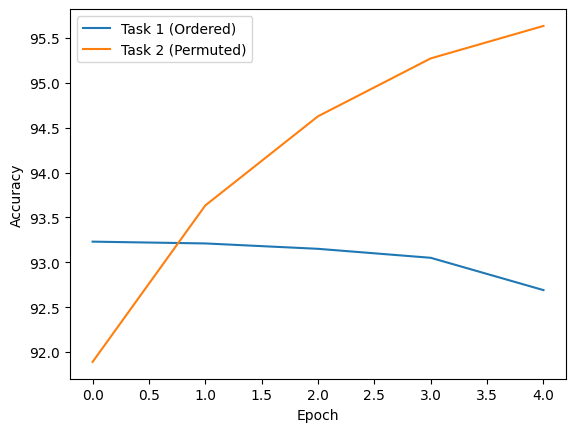

Training permuatation 2
Epoch [1/5], Loss: 0.3960
Epoch [2/5], Loss: 0.2266
Epoch [3/5], Loss: 0.1882
Epoch [4/5], Loss: 0.1650
Epoch [5/5], Loss: 0.1487


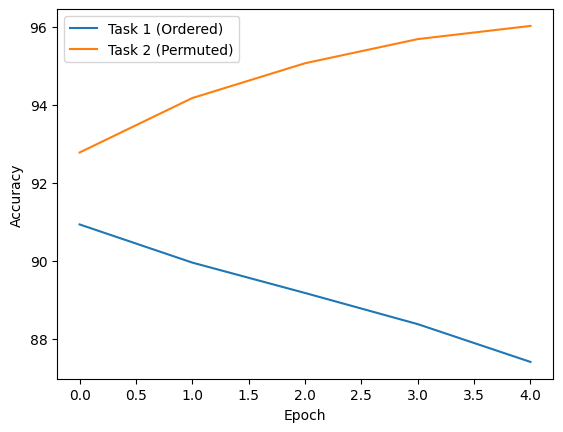

Training permuatation 3
Epoch [1/5], Loss: 0.3995
Epoch [2/5], Loss: 0.2170
Epoch [3/5], Loss: 0.1762
Epoch [4/5], Loss: 0.1524
Epoch [5/5], Loss: 0.1361


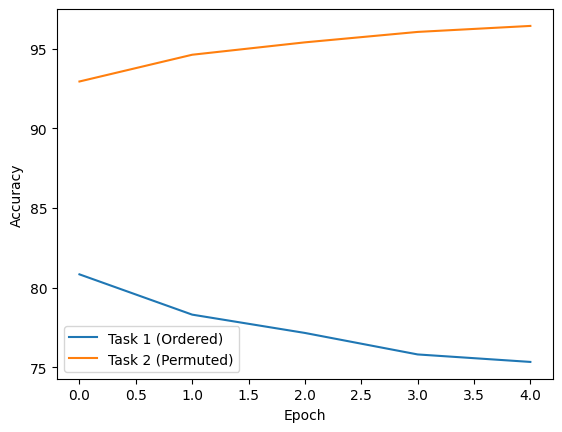

Training permuatation 4
Epoch [1/5], Loss: 0.3840
Epoch [2/5], Loss: 0.2126
Epoch [3/5], Loss: 0.1741
Epoch [4/5], Loss: 0.1518
Epoch [5/5], Loss: 0.1363


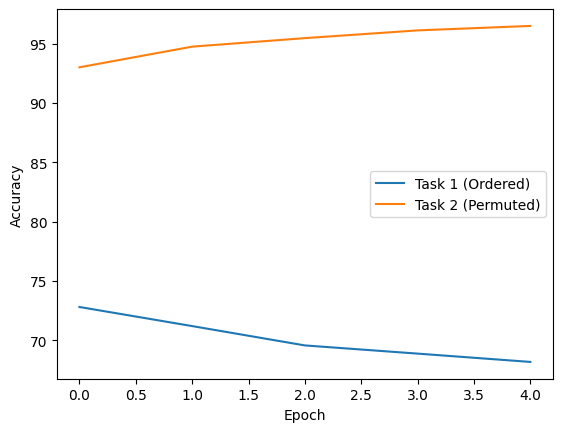

In [48]:
import copy

num_tasks = 5

saved_models_list = []

model = SimpleMLP()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 5

print("=== Training on Task 1 ===")
train_model(model, optimizer, criterion, train_loader_task1, test_loader_task1, num_epochs)
acc_task1_before = evaluate(model, test_loader_task1)
temp_model = copy.deepcopy(model)
saved_models_list.append(temp_model)

for i in range(1, num_tasks):
  print(f'Training permuatation {i}')
  perm = torch.randperm(784)
  permuted_train_dataset = PermutedMNIST(full_train_dataset, perm)
  permuted_test_dataset = PermutedMNIST(full_test_dataset, perm)
  train_loader_permuted = DataLoader(dataset=permuted_train_dataset, batch_size=batch_size, shuffle=True)
  test_loader_permuted = DataLoader(dataset=permuted_test_dataset, batch_size=batch_size, shuffle=True)
  test_loaders_list.append(test_loader_permuted)


  train_model(model, optimizer, criterion, train_loader_permuted, test_loader_permuted, num_epochs)
  temp_model = copy.deepcopy(model)
  saved_models_list.append(temp_model)


In [ ]:
import copy

model = SimpleMLP()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print("=== Training on Task 1 ===")
train_model(model, optimizer, criterion, train_loader_task1, num_epochs_first)

acc_task1_before = evaluate(model, test_loader_task1)
acc_task2_before = evaluate(model, test_loader_task2)
print(f"After Task 1 training - Test accuracy on Task 1: {acc_task1_before:.2f}%")
print(f"After Task 1 training - Test accuracy on Task 2: {acc_task2_before:.2f}%")

task1_model = copy.deepcopy(model)

print("\n=== Training on Task 2 ===")
train_model(model, optimizer, criterion, train_loader_task2, num_epochs_second)

acc_task1_after = evaluate(model, test_loader_task1)
acc_task2_after = evaluate(model, test_loader_task2)
task2_model = copy.deepcopy(model)

print(f"\nAfter Task 2 training - Test accuracy on Task 1: {acc_task1_after:.2f}%")
print(f"After Task 2 training - Test accuracy on Task 2: {acc_task2_after:.2f}%")

In [ ]:
# ------- imports -------
import numpy as np
import matplotlib.pyplot as plt
from torch.linalg import svdvals
from sklearn.decomposition import PCA

# ------- 1. WEIGHT ANALYSIS -------
layer_indices = [1, 3]                 # indices within model.net (Sequential) for Linear layers
for idx in layer_indices:
    w1 = task1_model.net[idx].weight.detach().cpu().numpy()
    w2 = task2_model.net[idx].weight.detach().cpu().numpy()

    # Plot distributions + difference + singular values
    plt.figure(figsize=(12,4))

    # A) weight histograms
    plt.subplot(1,3,1)
    plt.hist(w1.flatten(), bins=50, alpha=0.6, label='Task1')
    plt.hist(w2.flatten(), bins=50, alpha=0.6, label='Task2')
    plt.title(f'Layer {idx} weights')
    plt.legend()

    # B) difference histogram
    plt.subplot(1,3,2)
    plt.hist((w2 - w1).flatten(), bins=50, color='gray')
    plt.title('Δ weights (Task2 − Task1)')

    # C) singular‐value spectra
    s1 = svdvals(task1_model.net[idx].weight.detach().cpu())
    s2 = svdvals(task2_model.net[idx].weight.detach().cpu())
    plt.subplot(1,3,3)
    plt.plot(s1.cpu(), label='Task1')
    plt.plot(s2.cpu(), label='Task2')
    plt.title('Singular values')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Relative Frobenius‐norm change
    rel_change = np.linalg.norm(w2 - w1) / np.linalg.norm(w1)
    print(f'Layer {idx} relative ‖ΔW‖/‖W₁‖ = {rel_change:.4f}\n')

# ------- 2. ACTIVATION ANALYSIS -------
# hooks to grab activations
activations1, activations2 = {}, {}
def make_hook(name, store):
    def hook(module, inp, out):
        store[name] = out.detach().cpu()
    return hook

# pick the same layers: Linear(28*28→64), ReLU, Linear(64→10)
names    = ['fc1', 'relu', 'fc2']
mods1    = [task1_model.net[1], task1_model.net[2], task1_model.net[3]]
mods2    = [task2_model.net[1], task2_model.net[2], task2_model.net[3]]
for nm, m1, m2 in zip(names, mods1, mods2):
    m1.register_forward_hook(make_hook(nm, activations1))
    m2.register_forward_hook(make_hook(nm, activations2))

# run one batch of test images through both
batch_imgs, batch_lbls = next(iter(test_loader_task1))
batch_imgs = batch_imgs.to(device)
_ = task1_model(batch_imgs)
_ = task2_model(batch_imgs)

# PCA + scatter for each layer
for nm in names:
    A1 = activations1[nm].reshape(batch_imgs.size(0), -1).numpy()
    A2 = activations2[nm].reshape(batch_imgs.size(0), -1).numpy()

    for A, title in [(A1,'Task1'), (A2,'Task2')]:
        pca = PCA(n_components=2)
        pts = pca.fit_transform(A)

        plt.figure(figsize=(6,5))
        sc = plt.scatter(pts[:,0], pts[:,1],
                         c=batch_lbls.numpy(), cmap='tab10', alpha=0.7)
        plt.colorbar(sc, ticks=range(10), label='digit label')
        plt.title(f'PCA of {nm} activations — {title}')
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.show()



In [ ]:
# ------- imports for 3D plotting -------
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# layer names and corresponding modules in your Sequential
names = ['fc1','relu','fc2']
mods = [lambda m: m.net[1], lambda m: m.net[2], lambda m: m.net[3]]

# helper to register hooks & run a single batch
def get_activations(model, loader):
    acts = {nm: None for nm in names}
    hooks = []
    for nm, getmod in zip(names, mods):
        hooks.append(getmod(model).register_forward_hook(
            lambda m, inp, out, nm=nm: acts.__setitem__(nm, out.detach().cpu())
        ))
    # grab one batch
    imgs, labels = next(iter(loader))
    _ = model(imgs.to(device))
    for h in hooks: h.remove()
    return acts, labels.cpu().numpy()

# extract four sets of activations & labels
a11, lbls1 = get_activations(task1_model, test_loader_task1)  # task1_model on task1 inputs
a12, lbls2 = get_activations(task1_model, test_loader_task2)  # task1_model on task2 inputs
a21, _     = get_activations(task2_model, test_loader_task1)  # task2_model on task1 inputs
a22, _     = get_activations(task2_model, test_loader_task2)  # task2_model on task2 inputs

# now plot
for nm in names:
    fig = plt.figure(figsize=(12,10))
    for i, (acts, lbls, title) in enumerate([
        (a11[nm], lbls1, 'T1-model on T1 inputs'),
        (a12[nm], lbls2, 'T1-model on T2 inputs'),
        (a21[nm], lbls1, 'T2-model on T1 inputs'),
        (a22[nm], lbls2, 'T2-model on T2 inputs'),
    ]):
        # reshape to (batch, features)
        X = acts.reshape(acts.shape[0], -1).numpy()
        pca = PCA(n_components=3)
        X3 = pca.fit_transform(X)

        ax = fig.add_subplot(2,2,i+1, projection='3d')
        sc = ax.scatter(X3[:,0], X3[:,1], X3[:,2],
                        c=lbls, cmap='tab10', alpha=0.7)
        ax.set_title(f'{nm} — {title}')
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

    # shared colorbar
    # cbar = fig.colorbar(sc, ax=fig.get_axes(),
    #                     shrink=0.5, orientation='horizontal', pad=0.1,
    #                     ticks=range(10))
    cbar.set_label('digit label')
    plt.suptitle(f'3-D PCA of "{nm}" activations', y=0.92, fontsize=16)
    plt.tight_layout()
    plt.show()


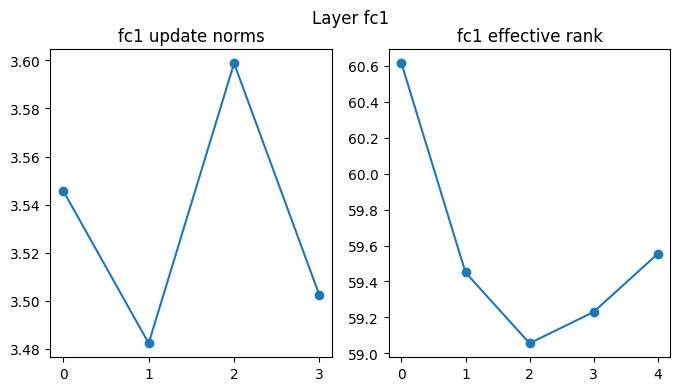

fc1 total trajectory length: 14.1292


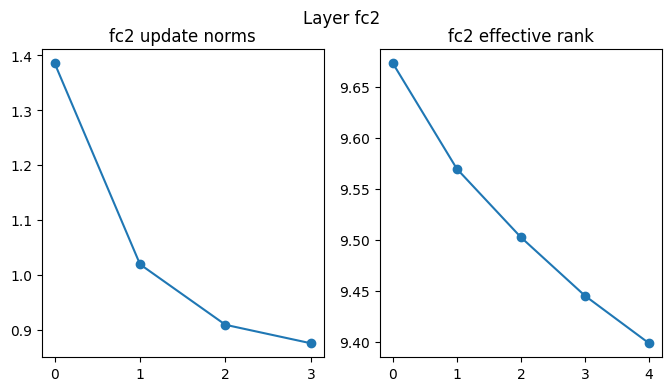

fc2 total trajectory length: 4.1900


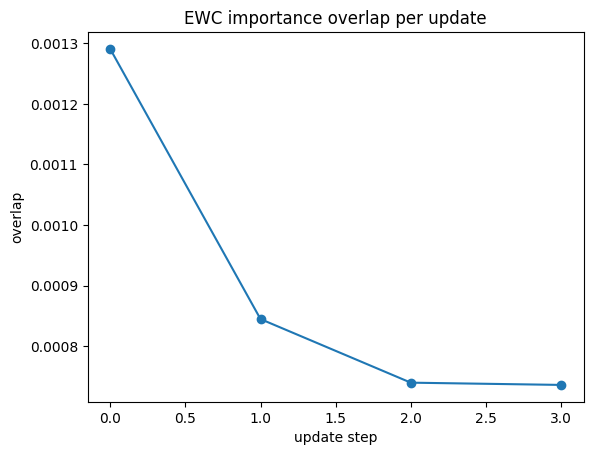

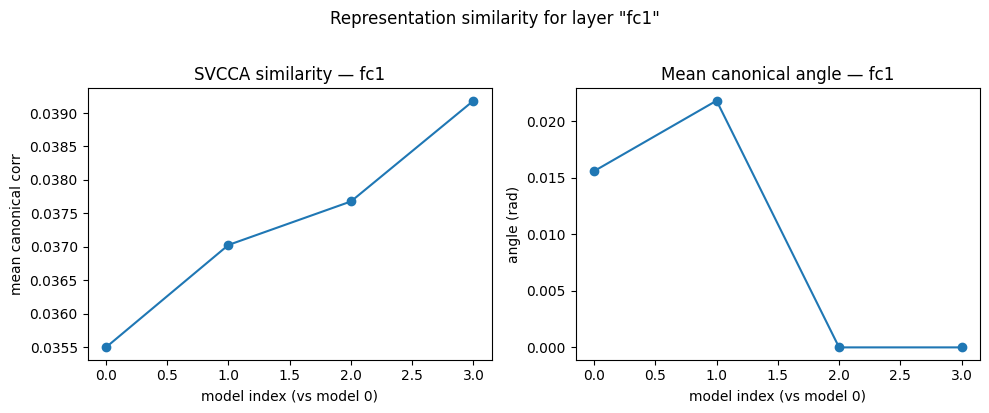

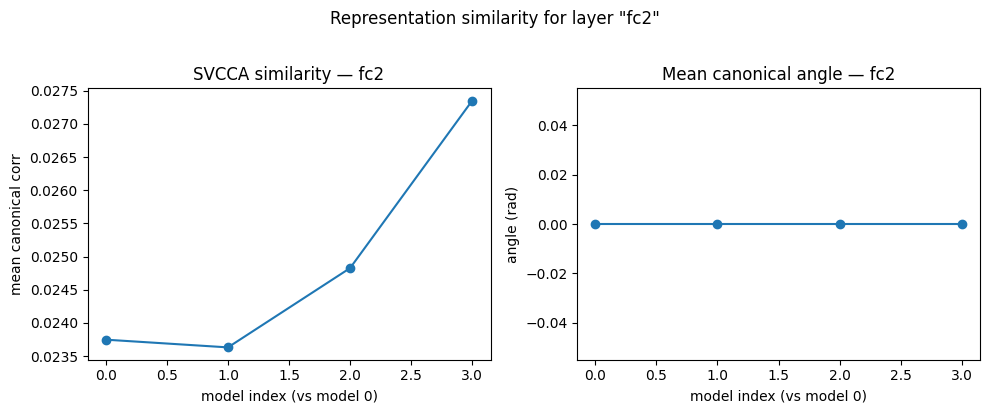

Class radii (fc1): {np.int64(0): np.float32(12.058285), np.int64(1): np.float32(7.6545324), np.int64(2): np.float32(12.725557), np.int64(3): np.float32(10.961711), np.int64(4): np.float32(9.69757), np.int64(5): np.float32(12.390899), np.int64(6): np.float32(11.072449), np.int64(7): np.float32(10.148164), np.int64(8): np.float32(10.417805), np.int64(9): np.float32(9.307791)}
Manifold dims (fc1): {np.int64(0): np.int64(9), np.int64(1): np.int64(6), np.int64(2): np.int64(10), np.int64(3): np.int64(11), np.int64(4): np.int64(11), np.int64(5): np.int64(9), np.int64(6): np.int64(9), np.int64(7): np.int64(9), np.int64(8): np.int64(12), np.int64(9): np.int64(10)}
Cluster separability (fc1): 0.9923352473695877


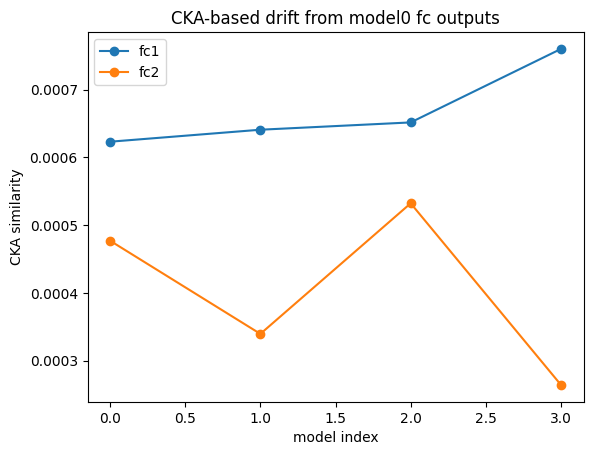

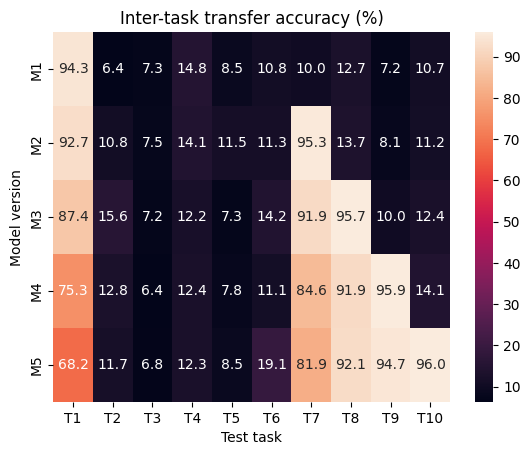

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.linalg import svdvals
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# ASSUMPTIONS (define these in your notebook before running):
# saved_models_list = [model0, model1, ..., model4]
# test_loaders_list = [test_loader_task1, ..., test_loader_task5]
train_loader_ewc = train_loader_task1
criterion = nn.CrossEntropyLoss()
device = 'cuda' or 'cpu'

# Move all models to CPU and eval mode for analysis
for m in saved_models_list:
    m.to('cpu').eval()

# 1+2+3: weight norms, effective rank, parameter‐space trajectory
layers = [('fc1', lambda m: m.net[1]), ('fc2', lambda m: m.net[3])]
weights = {name: [] for name, _ in layers}
for model in saved_models_list:
    for name, getm in layers:
        W = getm(model).weight.detach().cpu().numpy()
        weights[name].append(W)

# Compute metrics
norms = {name: [] for name, _ in layers}
eranks = {name: [] for name, _ in layers}
traj_lengths = {name: 0.0 for name, _ in layers}
for name in norms:
    for i in range(len(weights[name]) - 1):
        dW = weights[name][i+1] - weights[name][i]
        norms[name].append(np.linalg.norm(dW))
        traj_lengths[name] += np.linalg.norm(dW)
    for W in weights[name]:
        sv = np.linalg.svd(W, compute_uv=False)
        p = sv / sv.sum()
        eranks[name].append(np.exp(-np.sum(p * np.log(p + 1e-12))))

# 4: EWC Fisher diag on first model
def compute_fisher(model, dataloader, criterion):
    fishers = {n: torch.zeros_like(p) for n,p in model.named_parameters()}
    for imgs, labels in dataloader:
        model.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        for n, p in model.named_parameters():
            fishers[n] += p.grad.data.pow(2)
    for n in fishers:
        fishers[n] /= len(dataloader)
    return fishers

fisher = compute_fisher(saved_models_list[0].to('cpu'), train_loader_ewc, criterion)
ewc_overlap = []
for i in range(len(saved_models_list)-1):
    model_prev = saved_models_list[i]
    model_next = saved_models_list[i+1]
    overlap = 0.0
    for n, p in model_prev.named_parameters():
        delta = (model_next.state_dict()[n] - p.data).cpu()
        overlap += (fisher[n] * delta.pow(2)).sum().item()
    ewc_overlap.append(overlap)

# 5: SVCCA and 6: canonical angles
def svcca(X, Y, max_components=20):
    """
    Mean canonical correlation after PCA to L dims,
    where L = min(n_samples, n_features, max_components).
    """
    n_samples, n_features = X.shape
    L = min(n_samples, n_features, max_components)
    # 1) PCA-reduce
    Xr = PCA(n_components=L).fit_transform(X)
    Yr = PCA(n_components=L).fit_transform(Y)
    # 2) CCA on reduced dims
    cca = CCA(n_components=L)
    Xc, Yc = cca.fit_transform(Xr, Yr)
    # 3) average corr per component
    corrs = [np.corrcoef(Xc[:, i], Yc[:, i])[0, 1] for i in range(L)]
    return np.mean(corrs)

# ---- canonical‐angles helper ----
def canonical_angles(X, Y):
    """
    Principal angles between row-spaces of X and Y:
    angles = arccos(singular_values(X^T Y)).
    """
    M = X.T.dot(Y)
    s = np.linalg.svd(M, compute_uv=False)
    # clamp to [-1,1] to avoid numerical errors outside domain
    s = np.clip(s, -1.0, 1.0)
    angles = np.arccos(s)
    return angles


# Activation extraction helper
def extract_acts(model, loader):
    acts = {name: [] for name, _ in layers}
    labels = []
    hooks = []
    for name, getm in layers:
        hooks.append(getm(model).register_forward_hook(
            lambda m, inp, out, n=name: acts[n].append(out.detach().numpy())
        ))
    for imgs, lbls in loader:
        labels.append(lbls.numpy())
        _ = model(imgs)
    for h in hooks: h.remove()
    # concatenate
    for n in acts:
        acts[n] = np.concatenate([a.reshape(a.shape[0], -1) for a in acts[n]], axis=0)
    labels = np.concatenate(labels, axis=0)
    return acts, labels

# Precompute activations for all models & loaders
acts = {}
for mi, model in enumerate(saved_models_list):
    acts[mi] = {}
    for ti, loader in enumerate(test_loaders_list):
        a, lbl = extract_acts(model, loader)
        acts[mi][ti] = (a, lbl)

# 7: manifold‐geometry & 8: cluster separability
def manifold_and_sep(X, labels):
    classes = np.unique(labels)
    centroids = {}
    radii = {}
    dims = {}
    for c in classes:
        Xi = X[labels==c]
        cent = Xi.mean(0)
        centroids[c] = cent
        radii[c] = np.linalg.norm(Xi-cent, axis=1).mean()
        pca = PCA().fit(Xi)
        cum = np.cumsum(pca.explained_variance_ratio_)
        dims[c] = np.searchsorted(cum, 0.9)+1
    # separability
    mu = X.mean(0)
    SW = np.zeros((X.shape[1],X.shape[1]))
    SB = np.zeros_like(SW)
    for c in classes:
        Xi = X[labels==c]
        mu_c = centroids[c]
        SW += (Xi-mu_c).T @ (Xi-mu_c)
        n_c = Xi.shape[0]
        diff = mu_c - mu
        SB += n_c * np.outer(diff, diff)
    sep = np.trace(SB)/np.trace(SW)
    return centroids, radii, dims, sep

manifold_metrics = {}
for mi in acts:                      # model index
    manifold_metrics[mi] = {}
    for ti in acts[mi]:              # task/input index
        manifold_metrics[mi][ti] = {}
        acts_dict, labels = acts[mi][ti]
        # unpack name, getter from layers
        for name, _ in layers:
            X   = acts_dict[name]   # (N, features)
            lbl = labels            # (N,)
            # compute centroids, radii, dims, separability
            manifold_metrics[mi][ti][name] = manifold_and_sep(X, lbl)


# 9: representational drift (CKA) relative to first model on task1 inputs
def linear_CKA(X, Y):
    Xc = X - X.mean(0)
    Yc = Y - Y.mean(0)
    HSIC = np.linalg.norm(Xc.T.dot(Yc), 'fro')**2
    denom = np.linalg.norm(Xc.T.dot(Xc), 'fro') * np.linalg.norm(Yc.T.dot(Yc), 'fro')
    return HSIC / denom

drift = {name: [] for name, _ in layers}
base_X = acts[0][0][0][name]  # model 0, loader 0
for name, _ in layers:
    base_X = acts[0][0][0][name]
    for mi in range(1, len(saved_models_list)):
        X = acts[mi][0][0][name]
        drift[name].append(linear_CKA(base_X, X))

# 10: inter‐task transfer (accuracy matrix)
acc_matrix = np.zeros((len(saved_models_list), len(test_loaders_list)))
for mi, model in enumerate(saved_models_list):
    for ti, loader in enumerate(test_loaders_list):
        correct = total = 0
        for imgs, lbls in loader:
            out = model(imgs)
            pred = out.argmax(1)
            correct += (pred == lbls).sum().item()
            total += lbls.size(0)
        acc_matrix[mi, ti] = 100 * correct / total

# --- VISUALIZATIONS ---
# Weight norms & effective rank
for name in norms:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(norms[name], marker='o')
    plt.title(f'{name} update norms')
    plt.subplot(1,2,2)
    plt.plot(eranks[name], marker='o')
    plt.title(f'{name} effective rank')
    plt.suptitle(f'Layer {name}')
    plt.show()
    print(f'{name} total trajectory length: {traj_lengths[name]:.4f}')

# EWC overlap
plt.figure()
plt.plot(ewc_overlap, marker='o')
plt.title('EWC importance overlap per update')
plt.xlabel('update step')
plt.ylabel('overlap')
plt.show()

# SVCCA & angles
for name, _ in layers:
    sv_vals, ang_vals = [], []
    # baseline activations: model 0 on loader 0
    base_acts, _ = acts[0][0]     # acts[model_idx][loader_idx] = (dict, labels)
    X0 = base_acts[name]         # shape = (n_samples, feature_dim)

    for mi in range(1, len(saved_models_list)):
        comp_acts, _ = acts[mi][0]
        Xi = comp_acts[name]
        sv_vals.append(svcca(X0, Xi))
        ang_vals.append(canonical_angles(X0, Xi).mean())

    # plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].plot(sv_vals, marker='o')
    axs[0].set_title(f'SVCCA similarity — {name}')
    axs[0].set_xlabel('model index (vs model 0)')
    axs[0].set_ylabel('mean canonical corr')

    axs[1].plot(ang_vals, marker='o')
    axs[1].set_title(f'Mean canonical angle — {name}')
    axs[1].set_xlabel('model index (vs model 0)')
    axs[1].set_ylabel('angle (rad)')

    plt.suptitle(f'Representation similarity for layer "{name}"', y=1.02)
    plt.tight_layout()
    plt.show()


# Manifold & separability for model 0 on task1 inputs
cent, rad, dims, sep = manifold_metrics[0][0]['fc1']
print('Class radii (fc1):', rad)
print('Manifold dims (fc1):', dims)
print('Cluster separability (fc1):', sep)

# Representational drift
for name in drift:
    plt.plot(drift[name], marker='o', label=name)
plt.title('CKA-based drift from model0 fc outputs')
plt.xlabel('model index')
plt.ylabel('CKA similarity')
plt.legend()
plt.show()

# Inter-task transfer heatmap
sns.heatmap(acc_matrix, annot=True, fmt=".1f",
            xticklabels=[f'T{j+1}' for j in range(acc_matrix.shape[1])],
            yticklabels=[f'M{i+1}' for i in range(acc_matrix.shape[0])])
plt.xlabel('Test task'); plt.ylabel('Model version')
plt.title('Inter-task transfer accuracy (%)')
plt.show()
